In [1]:
import os
import sys
import seaborn
import os.path as path 
from mpl_toolkits.mplot3d import Axes3D

ROOT_PATH = path.abspath(path.join(".."))
sys.path.insert(4, f"{ROOT_PATH}/src")

from utils import *
from models import *
from notebook_utils import *
from clean_data import *
from evaluate import *
from make_dataset import *
from data_loader import *
from configs.train import *
from train import *

%matplotlib inline

pd.options.mode.chained_assignment = None

## Introduction

Mandarin Chinese is a tonal language; each word has a tone label that changes its meaning. There are four commonly used tones in Chinese. The purpose of this project is to build a model to classify which tone a person is using, as good or better than native Mandarin Speakers.

Most sound recognition projects visualise data into spectrograms. Advancements in computer vision influenced this process. Spectrograms provide higher-dimensional information of the audio data, but they have weaknesses. Humans are better at detecting differences in lower frequencies. Spectrograms disregard this fact.

A Mel spectrogram is a combination of a spectrogram, and a Mel scale, transforming linear frequencies to represent sounds humans consider important. Mel spectrograms are the data I need to teach model similar to native speakers, avoiding added bias.

https://api.forvo.com/ is a website I used to request word pronunciations in Chinese. The variety of words and speakers improves the generalisation of the model.  Speech synthesis is less prone to error, but the model will be less applicable to the real world.

Audio pronunciation made from random people is bound to include error. To clean the data,  I removed excess silence, computed the PCA to remove outliers and used Speach Recognition to remove low-quality data. I sampled data with a representative tone distribution to remove added bias. 

There is tradeoff using this data cleaning method. Although the quality of the data improved, it removes nearly half of the dataset. Augmenting the data builds enough samples for this project. Through manipulating the frequencies or noise injection, I can create three times more of the dataset. Increasing the size of the data leads to a better variance of the model.

To finalise the data, I converted the audio files into Mel spectrograms, storing the pixels and the label into a NumPy array. Then I used a PyTorch DataLoader to convert the data into tensors. 

There are three models used in this project:
1. SimpleCNN: 5 convolutional layers with the least number of hidden units
2. ComplexCNN: 5 convolutional layers with more hidden units than the SimpleCNN
3. DeepCNN: 13 convolutional layers

All three models achieved above a 90% accuracy score on the test set. 
There was not much to separate the SimpleCNN and ComplexCNN. The DeepCNN performed the best achieving a score closer to 95%

The results confirm the data set I built is of high quality. The results show that this is a highly complex task the model is performing. High-level features are necessary for a model to perform well; this is why the DeepCNN performed the best on this project.

## Request Data

Building a list of unique Chinese characters.

In [2]:
chinese_words = extract_words(print_total=True)

# Total words: 10320.


Word examples

In [3]:
chinese_words[:10]

['冠', '病', '毒', '状', '三', '合', '症', '体', '综', '胶']

These two functions request the pronunciations and then save them.
* limit: maximum times you can request the same word from different people

Note: I can only make 500 requests per day, so I randomly sample 500 words each day.

In [4]:
mp3_urls = request_pronunciations(chinese_words, API_KEY, limit=4)
audio_list = save_pronunciations(mp3_urls)

100%|██████████| 752/752 [05:08<00:00,  2.43it/s]


Building a DataFrame and also appending the previous appended dataset.

In [5]:
audio_data = build_dataframe(audio_list)

Appending Previous Data Set!


The data frame includes information about the audio file's tone, word, and Id.

In [6]:
audio_data.head()

duration                     id  labels nframes  tone word
0  2.246531  audio_3765d7a5-1a.wav     1.0   99072   2.0    苻
1  2.560000  audio_8447e768-54.wav     0.0  112896   1.0    玎
2  3.056327  audio_1433233e-9d.wav     3.0  134784   4.0    玥
3  2.351020  audio_82e6fc9e-bf.wav     0.0  103680   1.0    馐
4  2.533878  audio_10ab3d25-1d.wav     0.0  111744   1.0    馐

In [7]:
audio_data.to_pickle(f"{DATA_PATH}/processed/Pickle/audio_df.pkl")

## Data Exploration


In [8]:
audio_data = pd.read_pickle(f"{DATA_PATH}/processed/Pickle/audio_df.pkl")

There are null values within the tone and label category, highlighting some error occurred extracting the tone.

In [9]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5695 entries, 0 to 5694
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  5695 non-null   float64
 1   id        5695 non-null   object 
 2   labels    5649 non-null   float64
 3   nframes   5695 non-null   object 
 4   tone      5649 non-null   float64
 5   word      5695 non-null   object 
dtypes: float64(3), object(3)
memory usage: 311.4+ KB


###  Tones

* Tone 1: pronounced in a high pitch
* Tone 2: a low to high pitch sound
* Tone 3: pronounced in a deep pitch
* Tone 4: a high to low pitch sound

Here are few examples of each tone:

In [10]:
play_tones(audio_data)

This confirms the dataset's tone distribution is representative of the real world.

In [11]:
display_tone_dist(chinese_words, audio_data)

There are few annomlies dected in the audio duration. 

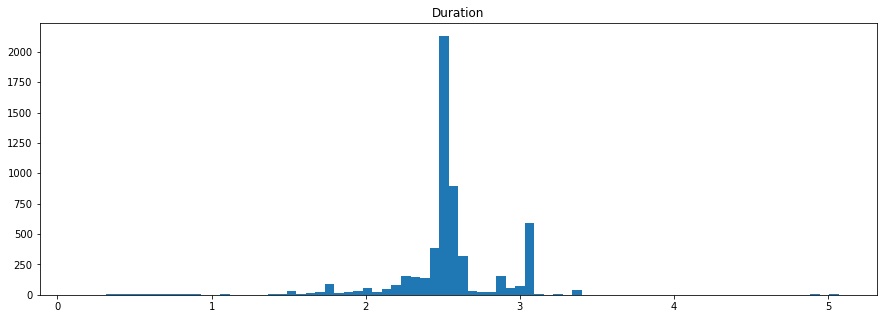

In [12]:
display_duration(audio_data)

The wave plots show that a huge portion of the audio files contain silence.

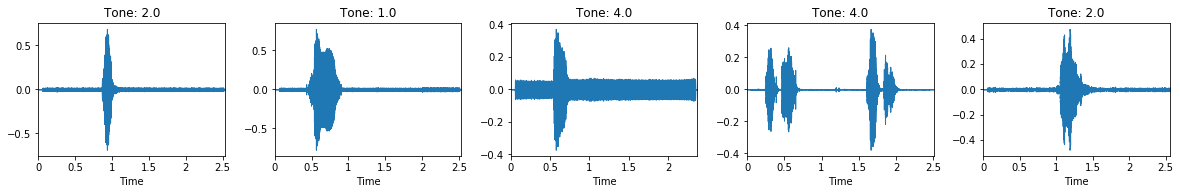

In [13]:
display_wave_plots(audio_data)

The Mel spectrograms provide more information about the audio files but difficult to interpret.

In [14]:
display_spectrogram(audio_data)

## Remove Silence

Majority of the audio files include excess silence. Removing silenceshortens the range and mean of the audio data's duration. Less padding is then required once building the Mel Spectrograms. As limits are placed on my computing resources (8GB GPU), removing silence reduces the memory of the data and training time.

Remove all null values in the data.

In [15]:
audio_data = audio_data.dropna()

A function that removes the silence from the audio files.

In [16]:
audio_data = remove_silence(audio_data)

100%|██████████| 5649/5649 [01:12<00:00, 78.22it/s] 


A comparison of the audio file with or without the silence removed.

In [17]:
play_audio_length(audio_data)

Word: 希, Tone: 1.0


After removing the silence, the duration range has decreased and has more of a normal distribution. Outliers are still visible, audio files longer than 2 seconds.

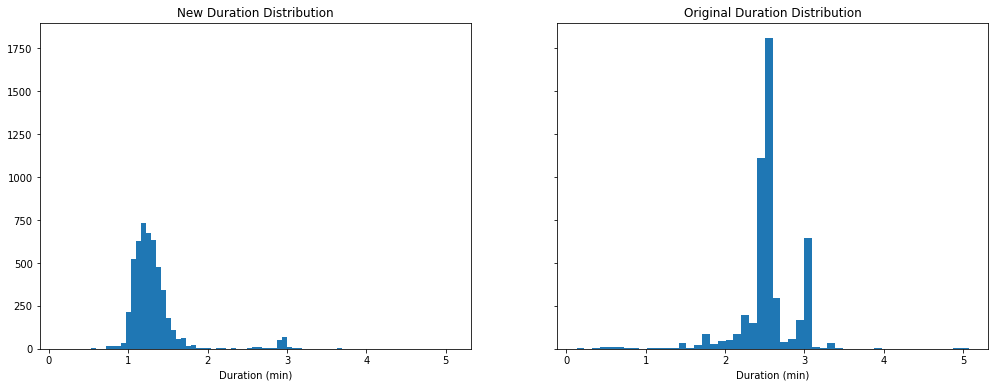

In [18]:
compare_duration(audio_data)

Audio files longer than 2 seconds tend to include more Gaussian noise; silenced was not identified, so nothing was removed.

Here are two examples of the longer audio files.

In [19]:
play_long_audio(audio_data)

Removing audio files longer than 2 seconds.

In [20]:
audio_data = audio_data[audio_data['new_duration'] < 2]

## Data Augmentation

The data cleaning process removes nearly half of the audio files. The remaining data is insufficient to prevent the model from overfitting.  Augmenting can solve this issue.

I can produce three variations of the same audio file by manipulating the frequencies, noise injection or shifting the sound. 

Here are examples of different audio types:

In [21]:
play_aug(audio_data)

There are noticeable differences within each wave plot of the same file.

In [22]:
display_aug(audio_data)

Now there are enough samples to prevent overfitting occurring.

In [23]:
audio_data_ag = audio_augmentation(audio_data)                   

100%|██████████| 4754/4754 [01:35<00:00, 49.78it/s] 

# Samples Added: 14262 


## PCA

Principle Component Analysis allows me to reduce the dimensions of the Mel Spectrograms, plot the residuals, and then identify any outliers or clusters within the data. Then an Isolation Forest is applied to determine whether or not an observation is an outlier.

A function that computes the PCA and the Isolation Forest.

In [24]:
audio_pca = pca_audio(audio_data_ag)
audio_pca = detect_outliers(audio_pca)
audio_pca.to_pickle(f"{DATA_PATH}/processed/Pickle/audio_pca.pkl")

100%|██████████| 19016/19016 [04:45<00:00, 66.65it/s] 


There are no visible tone clusters. Not enough data was retained during the PCA to represent the differences in tones.

In [25]:
display_pca_tones(audio_pca)

There are visible audio type clusters, especially the audio with added noise.

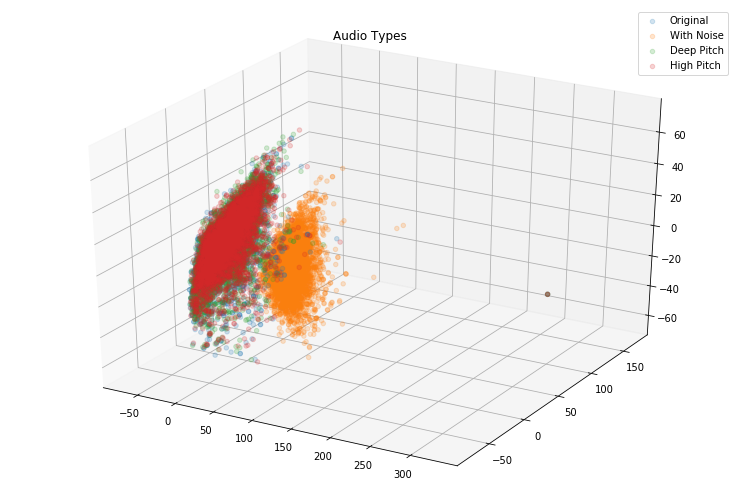

In [26]:
display_pca_types(audio_pca)   

The data set includes a few outliers.

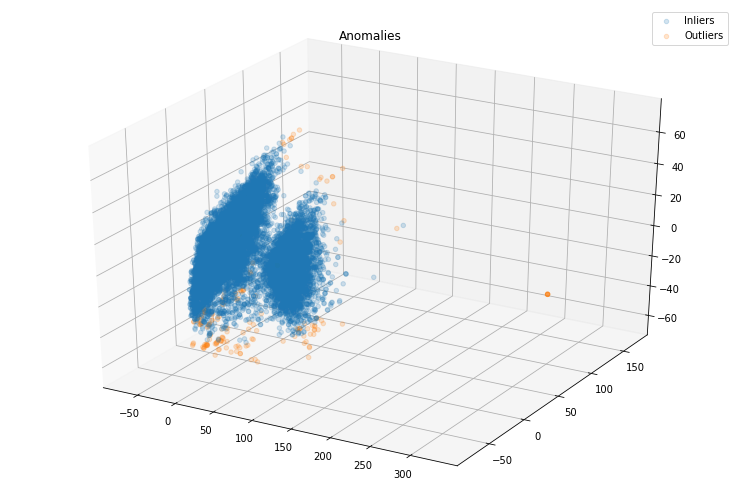

In [27]:
display_outliers(audio_pca)

Error is more common in the audio files labelled as outliers, but this is not always the case. There is not enough information retained during the PCA to make this strong assumption. 

In [28]:
play_anomalies(audio_pca)

Tone: 4.0	Anomaly: 1	Audio Type: CL


Tone: 2.0	Anomaly: -1	Audio Type: WN


I removed the outliers as they could affect model performance.

In [29]:
audio_inlier = audio_pca[audio_pca.anomaly == 1]

## Speech Recognition

Google Speech Recognition is used to detect mislabeled, incomprehensible, and inconsistent audio data.


To label the quality of the data,  I made assumptions based on the results of the transcription task:
* 0: if one of the transcripts match the word
* 1: if one of the transcript's tone matches the tone
* 2: if none of the transcripts matches the word or the tone


In [30]:
audio_cln = speech_recognition_assessment(audio_inlier)

100%|██████████| 18825/18825 [22:55<00:00, 13.69it/s] 


The low-quality audio files are more likely to be mislabeled or lack clarity. Using this data will confuse our model as it won't be able to separate patterns in each class.

In [31]:
play_audio_quality(audio_cln)

Tone: 4.0	Sound Quality: 0.0	Audio Type: WN


Tone: 1.0	Sound Quality: 2.0	Audio Type: CL


I only select data that have sound quality 0 or 1, removing nearly half of the augmented dataset. 

In [32]:
data_count = len(audio_inlier)
audio_best = audio_cln[audio_cln.sound_quality <= 1]
print(f'# Samples Removed: {data_count - len(audio_best)}')

# Samples Removed: 8598


## Sampling Data

Within this process, I plan on sampling data representative of the real-world tone distribution to remove bias.

The distribution of the tones in the dataset does not match the real world, indicating there is added bias. 

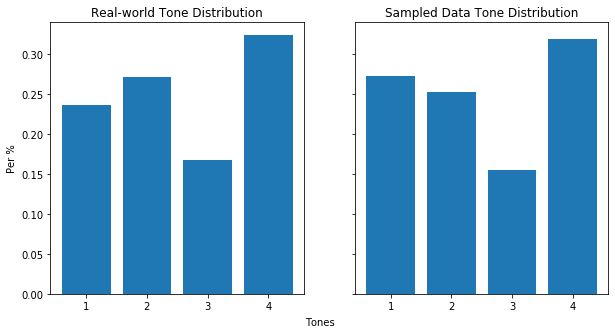

In [33]:
display_tone_dist(chinese_words, audio_best, file_path='tone_distrib2.png')

A function that retrieves the real-world tone distribution as a pandas Series.

In [34]:
tone_per = get_tone_dist(chinese_words)

This function samples the data to match the real-world tone distribution.

In [35]:
audio_pr = sample_tone_per(audio_best, tone_per)

# Samples Removed: 785 


Our sampled data tone distribution is now representative.

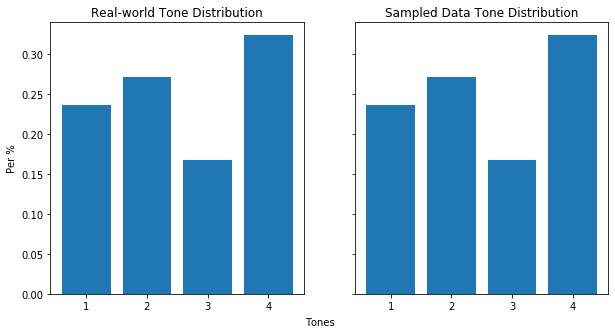

In [36]:
display_tone_dist(chinese_words, audio_pr, file_path='tone_distrib3.png')

In [37]:
print(len(audio_pr))

9442


## Data Preperation

Splitting the data

In [43]:
train, valid, test = split_data(audio_pr, test_per=0.05, val_per=0.10)

# Train Size: 8026
# Valid Size: 944
# Test Size: 472


Here I convert the audio files into Mel spectrograms and then load them into PyTorch tensor. 

The duration indicates the length I will transform each audio file using padding, ensuring each spectrogram has the same dimensions. 

In [44]:
train_loader, valid_loader, test_loader = prepare_data(train, valid, test, train_batch_size=32, val_batch_size=32, test_batch_size=32, duration=2)

100%|██████████| 472/472 [00:07<00:00, 62.51it/s]


## Train

There are three models of different complexities in this project. Comparing the results gives me a strong basis on ways to tune the model for optimum performance.

In [45]:
loss_func = nn.CrossEntropyLoss()
configs = {'lr_decay': False, 'epochs': 50, 'patience': 20, 'lr': 1e-04, 'optim':'adam', 'early_stop': True}
configs = pd.Series(configs)

train_loader = load_object(f"{INTERIM_PATH}/train_loader.pkl")
valid_loader = load_object(f"{INTERIM_PATH}/valid_loader.pkl")

### SimpleCNN

The SimpleCNN has the least number of hidden units.

In [46]:
simpleCNN = SimpleCNN()

In [47]:
train_model(configs, simpleCNN, loss_func, train_loader, valid_loader, print_info=False, print_epoch=10)

Epoch: 1/50
Train-Loss : 1.0337756751068086	Valid-Loss :0.6680686175823212	Valid-Accuracy : 0.7711864406779662
Epoch: 10/50
Train-Loss : 0.022688388518118986	Valid-Loss :0.41041085484127204	Valid-Accuracy : 0.8961864406779662
Epoch: 20/50
Train-Loss : 0.018256129293482932	Valid-Loss :0.5077159341424704	Valid-Accuracy : 0.8961864406779662
Early stopping
Best val Acc: 0.906780
Min val Loss: 0.327688


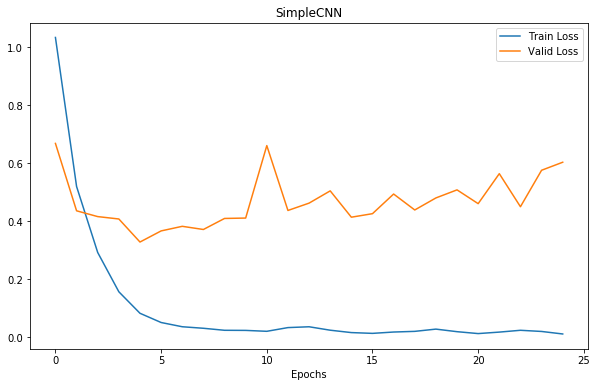

In [48]:
display_model_loss(simpleCNN)

### ComplexCNN

The ComplexCNN has a higher number of hidden units than the SimpleCNN but the same number of layers. Comparing the results of these two models tells me if the number of hidden units has an effect on performance. 

In [49]:
complexCNN = ComplexCNN()

In [50]:
train_model(configs, complexCNN, loss_func, train_loader, valid_loader, print_info=False, print_epoch=10)

Epoch: 1/50
Train-Loss : 1.2378525593841219	Valid-Loss :0.7217963774998982	Valid-Accuracy : 0.7521186440677966
Epoch: 10/50
Train-Loss : 0.04637800021105413	Valid-Loss :0.4304200533777475	Valid-Accuracy : 0.902542372881356
Epoch: 20/50
Train-Loss : 0.02560574307178731	Valid-Loss :0.6973434600979089	Valid-Accuracy : 0.8983050847457628
Early stopping
Best val Acc: 0.903602
Min val Loss: 0.372805


In [51]:
display_model_loss(complexCNN)

## DeepCNN

The DeepCNN is composed of 13 covolutional layers. Comparing the results of this model with the others will highlight whether using more convolutional layers is useful for this project.

In [52]:
deepCNN = DeepCNN()

In [53]:
train_model(configs, deepCNN, loss_func, train_loader, valid_loader, print_info=False, print_epoch=10)

Epoch: 1/50
Train-Loss : 0.9569950621441541	Valid-Loss :1.159724807739258	Valid-Accuracy : 0.5561440677966102
Epoch: 10/50
Train-Loss : 0.06596271455217435	Valid-Loss :0.39350850600749254	Valid-Accuracy : 0.9046610169491526
Epoch: 20/50
Train-Loss : 0.017729222903211796	Valid-Loss :0.36263329073165856	Valid-Accuracy : 0.9258474576271186
Early stopping
Best val Acc: 0.933263
Min val Loss: 0.291513


In [54]:
display_model_loss(deepCNN)

The deepCNN performed the best on the validation set.

In [55]:
compare_model_loss(simpleCNN, complexCNN, deepCNN)

## Test Model

In [56]:
score = test_model(simpleCNN, test_loader)




  0%|          | 0/15 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
test_model(complexCNN, test_loader)

In [ ]:
test_model(deepCNN, test_loader)

## Conclusion

Each process taken in the data wrangling process is what leads to the high-performing models.  Data augmentation reduces the risk of overfitting. Removing outliers and speech recognition assessment improves the quality of the data. Sampling a representative tone class distribution allows the model to perform better in the real world.

Each model above 90% accuracy shows that I was close to achieving my goal of this project. But native speakers are not wrong 90% of the time. Limits placed on the request quota is one of the main things preventing me from achieving, human-level performance.
